# I. one Hidden Layer (ReLU)

- Unroll 28 time step
- Each step input size: 28 x 1
- Total Feed-forward input size : 28 x 28

## Load Dataset


In [2]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

print(train_dataset.train_data.size())
print(train_dataset.train_labels.size())
print(test_dataset.test_data.size())
print(test_dataset.test_labels.size())


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Make data Iterable

In [3]:
batch_size = 100
n_iters = 3000
num_epochs = n_iters /  (len(train_dataset)/batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

## building class (질문 첨부-해결!)

In [44]:
class RNNModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(RNNModel, self).__init__()
    
    # hidden dimensions
    self.hidden_dim = hidden_dim
    # hidden layers
    self.layer_dim = layer_dim

    # RNN 
    # (batch_dim, seq_dim, input_dim)
    self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

    # fc layer
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    # initialize hidden state with zero
    # (layer_dim, batch_size, hidden_dim)
    h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_() # 처음에 이걸 self.hidden_layer = layer_dim 이라고 해서 오류났었음. 오류 안나게 하려면 이부분을 self.hidden_layer라고 바꾸면 됨.

    # detach hidden sate to prevent vanishing gradients
    # BPTT(truncated backpropagation through time)이라는데 이건 이해했는데 왜 detach 해야되는지 솔직히 잘 모르겠음.
    out, hn = self.rnn(x, h0.detach())

    # index hidden state of the last time step
    # out.size() --> 100, 28, 100 (batch_size, sequence, hidden_size) # feature 0~9까지 10개니까 hidden_size는 10개임. 밑에 parameters: 보면 hidden_size는 feature갯수라고 나와있음. # 하... 방금 설명이 틀린거임.
    # 근데 여기서 드는 의문점. 위에 hidden_size는 hidden_state의 개수가 아니라, output_dim 이잖아? 그러면 결국에는, many to many 인 경우에 그렇다는 거고, 위의 경우에는 100->10 이니까 최종적으로는 10이 되는거네?
    # 내가 생각한게 맞나? ㅇㅇ맞음

    # out[:,-1,:] --> 100, 100 --> just want the last time step hidden size, since sequence is no needed at this moment
    # 하.. 그냥 결국 오타였네...
    out = self.fc(out[:,-1,:])

    # out.size() --> 100, 10
    return out

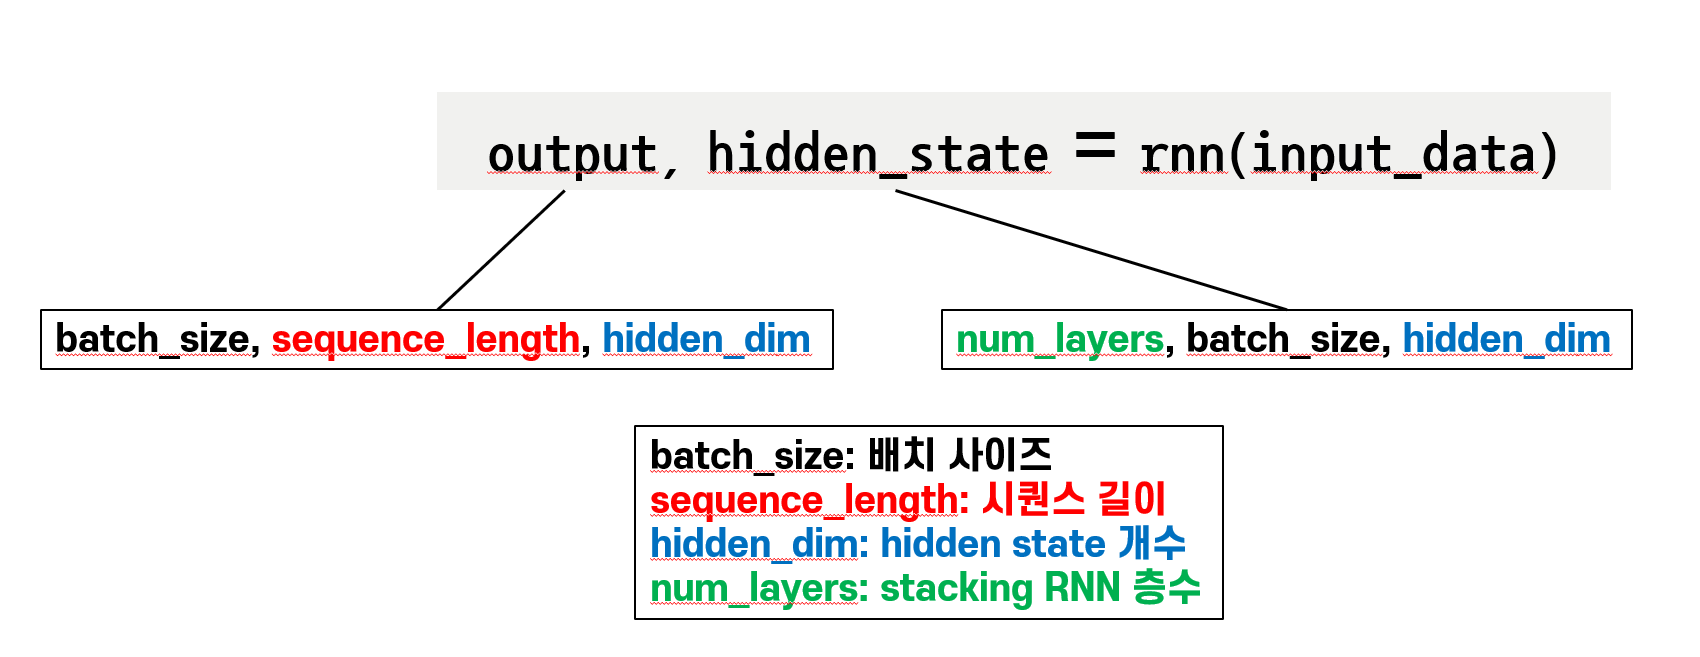

### nn.RNN Size가 헷갈려서 해본 코드

In [9]:
input = torch.randn(4,7,5)
# print(input) # 4개의, 7x5 행렬, 정규분포추출

input2 = torch.randn(2,4,10,3) # 2개의, 4개의, 10x3 행렬, 정규분포추출
# print(input2)
print(input2.size())

torch.Size([2, 4, 10, 3])


⭐ `nn.RNN`을 사용하게 되면 2개의 값을 반환하게 됨. output, hidden. 


- output_size = [sequence, batch_size, hidden_size] # where sequence is 문장의 개수, 단어를 입력한다고 할때

- hidden_size = [num_layer, batch_size, hidden_size] # where num_layer is STACKED number.

 - input_size = [sequence, batch_size, feature] # *where feature is 단어의 개수*
 
 ㄴ 이거 아니고, hidden_size = hidden state의 개수


pytorch는 모델에 데이터를 넣을 때는 batch_size를 가장 먼저 앞에 나옵니다. 

 

**하지만 RNN이나 LSTM 같은 경우는 batch_size가 아닌 sequence가 가장 먼저 나옵니다. 그럴때 사용하는 것이 batch_first = True 입니다. default는 False 입니다.**

⭐ What does detach() do in pyTorch?

✅ Returns a new Tensor, detached from the current graph


⭐ detach 해야되는 이유?

✅ hidden state isn’t suppose to be learned, so we detach it to let the model use those values but to not compute gradients.

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

참고한 자료: pyTorch 공식문서 nn.RNN

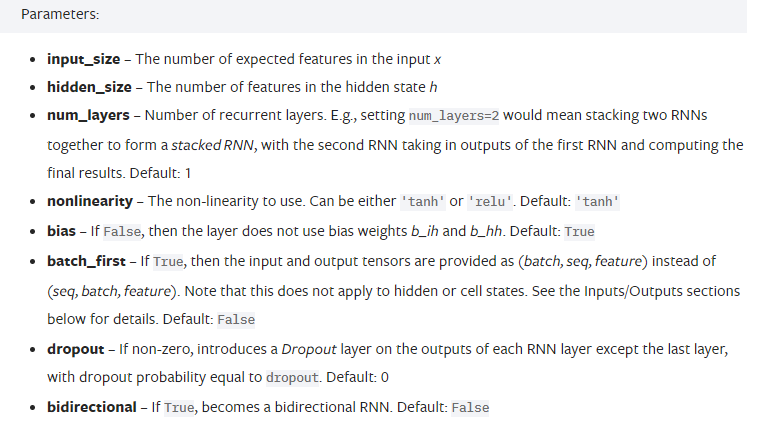

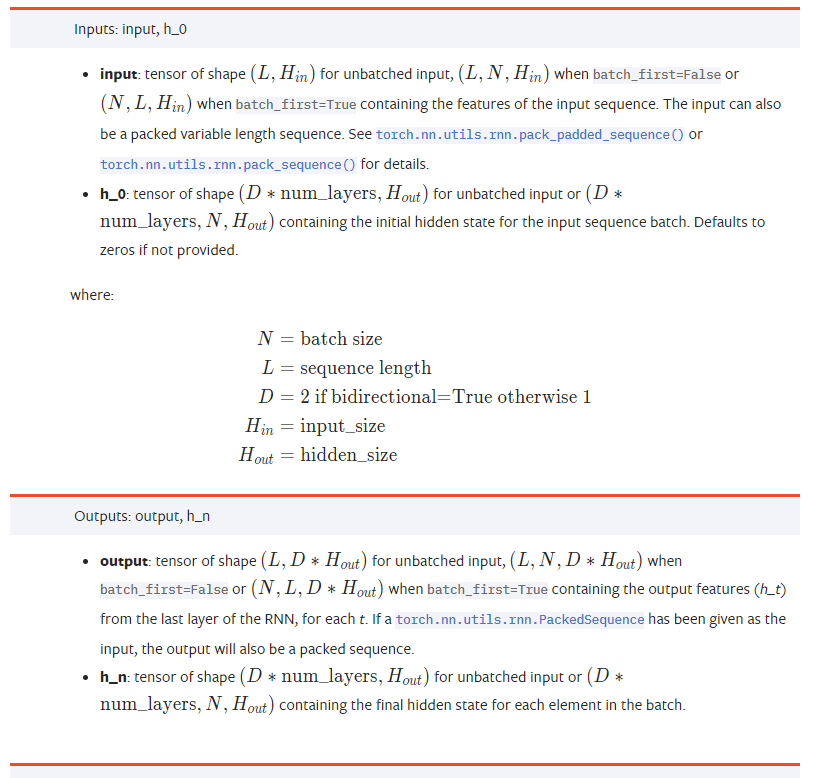

## Instantiate model class

In [45]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

In [46]:
model

RNNModel(
  (rnn): RNN(28, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)

## LOSS/Optimization

In [29]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

## total group of parameters

In [18]:
# total groups of paramters
len(list(model.parameters()))

6

In [20]:
# 1. input ~ hidden weight
list(model.parameters())[0].size()

torch.Size([100, 28])

In [21]:
# 2. input ~ hidden bias
list(model.parameters())[2].size()

torch.Size([100])

In [22]:
# 3. hidden ~ hidden weight
list(model.parameters())[1].size()

torch.Size([100, 100])

In [23]:
# 4. hidden ~ hidden bias
list(model.parameters())[3].size()

torch.Size([100])

In [25]:
# 5. hidden ~ output weight
list(model.parameters())[4].size()

torch.Size([10, 100])

In [26]:
# 6. hidden ~ output bias
list(model.parameters())[5].size()

torch.Size([10])

## Train

In [47]:
# number of steps to unroll
seq_dim = 28

iter = 0
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    model.train()

    # load images as tensors 
    images = images.view(-1, seq_dim, input_dim).requires_grad_()

    # clear gradients
    optimizer.zero_grad()

    # forward pass
    # outputs.size() --> 100, 10
    outputs = model(images)

    # loss
    loss = criterion(outputs, labels)

    # acquire gradients
    loss.backward()

    # upadate parameters
    optimizer.step()

    iter += 1
    if iter%500==0:
      model.eval()

      # calculate accuracy
      correct = 0
      total = 0
      
      # Iterate through test dataset
      for images, labels in test_loader:
        # load images to tensors with gradient accumulation ability
        images = images.view(-1, seq_dim, input_dim)

        # forward pass only to get logits/output
        outputs = model(images)

        # get predictions from maximum value
        _, predicted = torch.max(outputs.data, 1)

        # total number of labels
        total += labels.size(0)

        # total correct predictions
        correct += (predicted == labels).sum()
      
      accuracy = 100*correct/total

      print("Iteration:{}, Loss:{}, Accuracy:{}".format(iter, loss.item(), accuracy))

Iteration:500, Loss:2.302938461303711, Accuracy:9.800000190734863
Iteration:1000, Loss:2.2998604774475098, Accuracy:9.800000190734863
Iteration:1500, Loss:2.307339906692505, Accuracy:9.800000190734863
Iteration:2000, Loss:2.298846483230591, Accuracy:9.800000190734863
Iteration:2500, Loss:2.3108327388763428, Accuracy:9.800000190734863
Iteration:3000, Loss:2.3147709369659424, Accuracy:9.800000190734863


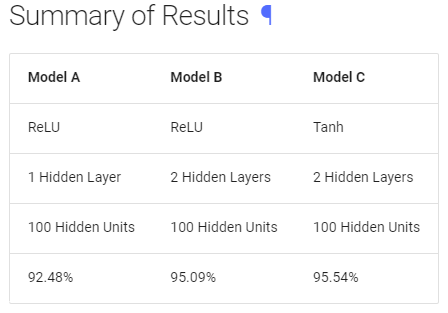

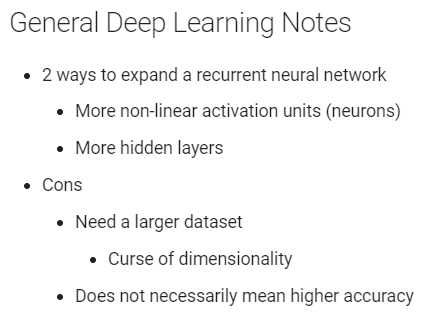